In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


### load data

In [2]:
# demand factor

file = open('../../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file)

file.close()

s_demand.describe()

count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [3]:
# VRE capacity factor 

file1 = open('../../preprocessing/df_VRE.pkl', 'rb')

df_VRE = pickle.load(file1)

file1.close()

df_VRE.describe()

,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [4]:
# bootstrap selections
file2 = open('../copperplate/M_bootstrap.pkl', 'rb')

M_bootstrap = pickle.load(file2)

file2.close()

M_bootstrap.shape

(100, 17520)

In [5]:
df_cost=pd.read_csv('../../raw_data/gencost_2223_summary.csv', skiprows=1, index_col=0)
df_cost

,CAP [AUD/kW],fixed O&M [AUD/kW/yr],variable O&M [AUD/MWh],CO2 store [AUD/MWh],fuel [AUD/MWh]
technology,,,,,
onshore,1642,25.00,0.0,0.0,0.000000
solar,498,17.00,0.0,0.0,0.000000
gasCCS,3012,16.35,7.2,1.9,106.568182


In [6]:
# capacity cost per MW per year, assuming 25 years economic life

cap_wind=df_cost.iloc[0,0]*1000/25 #[AUD/MW/yr]
cap_pv=df_cost.iloc[1,0]*1000/25 #[AUD/MW/yr]
cap_gas=df_cost.iloc[2,0]*1000/25 #[AUD/MW/yr]

fOM_wind=df_cost.iloc[0,1]*1000 #[AUD/MW/yr] 
fOM_pv=df_cost.iloc[1,1]*1000 #[AUD/MW/yr] 
fOM_gas=df_cost.iloc[2,1]*1000 #[AUD/MW/yr] 



# energy cost per MWh
gvar=df_cost.iloc[2, [2,3,4]].sum() # total variable cost of gas with CCS [AUD/MWh]

# check
print('CAP wind', cap_wind)
print('O&M wind', fOM_wind)
print('CAP pv', cap_pv)
print('O&M pv', fOM_pv)
print('CAP gas', cap_gas)
print('O&M gas', fOM_gas)
print('var cost of gas', gvar)


CAP wind 65680.0
O&M wind 25000.0
CAP pv 19920.0
O&M pv 17000.0
CAP gas 120480.0
O&M gas 16350.000000000002
var cost of gas 115.66818181818199


### zonal constraints

In [7]:
file1 = open('compute_constraints/Aub_zonal.pkl', 'rb')

Aub_zonal = pickle.load(file1)

file1.close()

file2 = open('compute_constraints/bub_zonal.pkl', 'rb')

bub_zonal = pickle.load(file2)

file2.close()

file3 = open('compute_constraints/lb_zones.pkl', 'rb')

lb_zones = pickle.load(file3)

file3.close()

print(Aub_zonal.shape, bub_zonal.shape, lb_zones)



(21, 32) (21,) ['ADE', 'SEQ', 'NCEN', 'MEL', 'TAS']


In [8]:
# template df to store the lagrange mulitplers of the zonal constraints
df_LM_template=pd.DataFrame(index=[col.split('_')[0]+'_max' for col in df_VRE.columns[:16]]+
                  [zone +'_min' for zone in lb_zones])
len(df_LM_template)

21

### determine cost values on the efficient frontier

In [9]:
#################
# min risk portfolio, computed from COV of full dataset
#################

P_cov=df_VRE.cov().values

Pd_cov=np.array([np.cov(s_demand, df_VRE[col])[0,1] for col in df_VRE.columns])

from qpsolvers import Problem, solve_problem
from scipy import sparse


problem_minrisk_all = Problem(P=P_cov, q=-Pd_cov, G=np.vstack([-np.repeat(1,32).reshape(1,-1), Aub_zonal]),
                              h=np.concatenate([np.array([-1]), bub_zonal]),  A=None, 
                              lb=np.zeros(32), ub=np.repeat(100, 32))                         
# quadprog is the best solver here
solution_minrisk_all = solve_problem(problem_minrisk_all, solver='quadprog', verbose=True)

print('optimal = ', solution_minrisk_all.is_optimal(1e-8))
print('objective =', solution_minrisk_all.obj+s_demand.var())

optimal =  True
objective = 0.011167899670461176


In [10]:
portfolio_minrisk_all=solution_minrisk_all.x
portfolio_minrisk_all

array([ 7.11115375e-02,  0.00000000e+00,  1.64726376e-02,  8.26925122e-02,
        9.97979579e-02,  1.46697044e-01,  5.59603976e-02, -4.73954405e-18,
        3.00803197e-02, -2.22848981e-18,  4.85072305e-02, -4.94235651e-18,
        2.36993900e-02,  2.55456589e-18,  3.36921400e-02,  3.85887976e-02,
       -3.89413759e-18,  6.72591412e-02, -1.37571287e-18, -2.31688358e-18,
       -6.88595132e-19,  1.87010639e-16,  4.54467464e-02, -2.46123075e-17,
        1.20841044e-01,  3.03199234e-17,  3.72839012e-20, -4.38535741e-17,
        3.33572848e-17,  9.57582989e-04,  9.50491248e-02,  2.31463962e-02])

In [11]:
portfolio_minrisk_all.sum()

1.0000000000000007

In [12]:
################
# min cost portfolio, sample 3 years
################

from scipy.optimize import linprog

_s_demand=s_demand.loc[(s_demand.index.year>=2004)& (s_demand.index.year<=2006)]
_df_VRE=df_VRE.loc[(df_VRE.index.year>=2004)& (df_VRE.index.year<=2006)]

M_p=_df_VRE.values


T=len(_s_demand) # number of hours / time steps
N_years=3

v_VREfixed=np.concatenate([np.repeat((cap_wind + fOM_wind),16) , np.repeat((cap_pv + fOM_pv),16)])
v_allfixed=np.append(v_VREfixed, cap_gas + fOM_gas)

# objective
c=np.concatenate([v_allfixed , np.repeat(gvar/N_years, T)]) # v_x =[X_i, X_g, g_t]

# equality constraint: there is none

#inequality constraints
## no demand deficit
Aub_demand=np.hstack([-M_p, np.zeros((T,1)), -np.identity(T)])
bub_demand=-(_s_demand.values)
## capacity of gas
Aub_gas=np.hstack([np.zeros((T,32)), -np.ones((T,1)),  np.identity(T)])
bub_gas=np.zeros(T)
## VRE IC
Aub_IC=np.concatenate([np.repeat(-1, 32), np.repeat(0, T+1)]).reshape(1,-1)
bub_IC=-1


Aub=np.vstack([Aub_demand, Aub_gas, Aub_IC, np.hstack([Aub_zonal, np.zeros((Aub_zonal.shape[0], T+1))])])

bub=np.append(np.append(np.append(bub_demand, bub_gas), bub_IC), bub_zonal)

lb=np.repeat(0, len(c))
ub=np.concatenate([np.repeat(100, 32), np.repeat(1, T+1)])
bounds=[(lb[i], ub[i]) for i in range(len(lb))]

res = linprog(c, A_ub=Aub, b_ub=bub, bounds=bounds, method='highs-ipm')

print('2004-2006')
print(res.message)

print(res.fun)

portfolio_mincost_sample=res.x[:33]
print(portfolio_mincost_sample)


2004-2006
Optimization terminated successfully. (HiGHS Status 7: Optimal)
316904.4779353606
[0.07111154 0.14202784 0.03858909 0.08269251 0.09979796 0.16756052
 0.049131   0.11666017 0.4149957  0.         0.         0.05256746
 0.         0.23764266 0.         0.06173519 0.         0.
 0.02326945 0.         0.         0.         0.2647381  0.
 0.06073075 0.08632692 0.15437192 0.01040676 0.13867494 0.
 0.         0.         0.71877749]


In [13]:
s_rplus_mincost=pd.Series(index=df_VRE.index, data=s_demand-df_VRE.values@portfolio_mincost_sample[:-1]).clip(lower=0)
s_rplus_minrisk=pd.Series(index=df_VRE.index, data=s_demand-df_VRE.values@portfolio_minrisk_all).clip(lower=0)

annual_cost_mincost=v_allfixed@portfolio_mincost_sample+s_rplus_mincost.sum()/10*gvar
annual_cost_minrisk=v_allfixed@np.concatenate([portfolio_minrisk_all, np.array([s_rplus_minrisk.max()])])+\
s_rplus_minrisk.sum()/10*gvar

print(annual_cost_mincost, annual_cost_minrisk)

311823.6982288202 528398.7252822554


In [14]:
# try costs rangeing from 280000 to 560000

In [15]:
# function to determine the sampling points on the EF for each bootstrap run

LC_constraints_core=np.concatenate([np.arange(28, 33, 0.5)*10000, np.arange(33, 36)*10000, 
                                    np.arange(36, 44,2)*10000, np.arange(44, 54,4)*10000])
def EF_cost_constraints(cost_mincost, cost_minrisk):
    
    # pick out the core points within range
    LC_constraints=LC_constraints_core[np.where((LC_constraints_core>=cost_mincost) & 
                                            (LC_constraints_core<=cost_minrisk))]
    
    # determine where to insert extra sampling points at the beginning
    LC_diff_start=LC_constraints[0]-cost_mincost
    
    if LC_diff_start>2500:
        addC1=LC_constraints[0]-2000
        LC_constraints=np.insert(LC_constraints, 0, addC1)
        addC2=(addC1+cost_mincost)/2
        LC_constraints=np.insert(LC_constraints, 0, addC2)
    elif (LC_diff_start<2500) and (LC_diff_start>1250):
        addC1=(LC_constraints[0]+cost_mincost)/2
        LC_constraints=np.insert(LC_constraints, 0, addC1)
        addC2=(LC_constraints[1]+LC_constraints[2])/2
        LC_constraints=np.insert(LC_constraints, 2, addC2)

    else:
        addC1=(LC_constraints[0]+LC_constraints[1])/2
        LC_constraints=np.insert(LC_constraints, 1, addC1)
        addC2=(LC_constraints[0]+addC1)/2
        LC_constraints=np.insert(LC_constraints, 1, addC2)
        
    if (LC_constraints[0]-cost_mincost)>250:
        addC=(cost_mincost+LC_constraints[0])/2
        LC_constraints=np.insert(LC_constraints, 0, addC)
   
    
    

        
    
    return LC_constraints
    
    

In [16]:
EF_cost_constraints(312708.0990998978, 529531.0791697544)

array([313281.07432492, 313854.04954995, 315000.        , 317500.        ,
       320000.        , 325000.        , 330000.        , 340000.        ,
       350000.        , 360000.        , 380000.        , 400000.        ,
       420000.        , 440000.        , 480000.        , 520000.        ])

## main 

In [17]:
# VRE only has fixed costs = capital + O&M
v_VREfixed=np.concatenate([np.repeat((cap_wind + fOM_wind),16) , np.repeat((cap_pv + fOM_pv),16)])
# add gas fixed cost
v_allfixed=np.append(v_VREfixed, cap_gas + fOM_gas)

# each bootstrap sample is equivalent to 2 years of data
N_years=2

# number of rows in each bootstrap sample = number of time steps considered
T=M_bootstrap.shape[1]

In [18]:
from scipy.optimize import linprog

from qpsolvers import Problem, solve_problem
from scipy import sparse
from scipy.linalg import block_diag


EF=dict()

# lagrange multipliers
LM=dict()


for bs in [54]:
#for bs in range(3): # test
    
    print(bs)
    
    
    idx_selection=M_bootstrap[bs]
    
    
    _s_demand=s_demand.iloc[idx_selection].values
    _df_VRE=df_VRE.iloc[idx_selection]

    M_p=_df_VRE.values
    
    P_cov=_df_VRE.cov().values

    Pd_cov=np.array([np.cov(_s_demand, _df_VRE[col])[0,1] for col in _df_VRE.columns])
       
    # initialise output
    df_EF=pd.DataFrame(index=df_VRE.columns.to_list()+['gas'])
    df_LM=df_LM_template.copy()
    
    ###############
    # LP min cost potfolio
    ###############
    
    # linear cost objective
    
    c=np.concatenate([v_allfixed , np.repeat(gvar/N_years, T)]) # v_x =[X_i, X_g, g_t]
    
    # equality constraint: there is none

    #inequality constraints
    ## no demand deficit
    Aub_demand=np.hstack([-M_p, np.zeros((T,1)), -np.identity(T)])
    bub_demand=-(_s_demand)
    ## capacity of gas
    Aub_gas=np.hstack([np.zeros((T,32)), -np.ones((T,1)),  np.identity(T)])
    bub_gas=np.zeros(T)
    ## VRE IC
    Aub_IC=np.concatenate([np.repeat(-1, 32), np.repeat(0, T+1)]).reshape(1,-1)
    bub_IC=-1
    # combine all, plus zonal constraints
    Aub=np.vstack([Aub_demand, Aub_gas, Aub_IC, np.hstack([Aub_zonal, np.zeros((Aub_zonal.shape[0], T+1))])])

    bub=np.append(np.append(np.append(bub_demand, bub_gas), bub_IC), bub_zonal)
    
    lb=np.repeat(0, len(c))
    ub=np.concatenate([np.repeat(100, 32), np.repeat(1, T+1)])
    
    boundslp=[(lb[i], ub[i]) for i in range(len(lb))]
    
    # solve model    
    m_mincost = linprog(c, A_ub=Aub, b_ub=bub, bounds=boundslp, method= 'highs-ipm')
    if m_mincost.status!=0:
        print(bs, 'mincost is not optimal.')
    
    # output resulting portfolio
    portfolio_mincost=m_mincost.x[:33]
    VRE_portfolio_mincost=m_mincost.x[:32]
    df_EF[1]=portfolio_mincost
    
    # lagrange multipliers
    df_LM[1]=m_mincost.ineqlin.marginals[-21:] 
    
    # value of the cost objective
    cost_mincost=m_mincost.fun
    
    # compute the risk (sigma square)
    s_residual_mincost=_s_demand-M_p@VRE_portfolio_mincost
    risk_mincost=np.var(s_residual_mincost)
    
    print(cost_mincost)

    
    #################
    # min risk portfolio
    ################# 
        
    problem_minrisk = Problem(P=P_cov, q=-Pd_cov, G=np.vstack([-np.repeat(1,32).reshape(1,-1), Aub_zonal]),
                              h=np.concatenate([np.array([-1]), bub_zonal]), A=None, 
                              lb=np.zeros(32), ub=np.repeat(100, 32))                  
    m_minrisk = solve_problem(problem_minrisk, solver='quadprog', verbose=True)
    if m_minrisk.found is not True:
        print(bs, 'minrisk is not optimal.')
    
    portfolio_minrisk=m_minrisk.x
    risk_minrisk=m_minrisk.obj*2 # multiply by 2 to get variance  
    
    # compute portfolio cost
    
    v_rplus_minrisk=_s_demand-M_p@portfolio_minrisk
    v_rplus_minrisk[np.where(v_rplus_minrisk<0)]=0
    
    cost_minrisk=v_VREfixed@portfolio_minrisk+ (cap_gas + fOM_gas)*v_rplus_minrisk.max() +\
                v_rplus_minrisk.sum()*gvar/N_years
    print(cost_minrisk)

    
    ################
    # samples along the EF
    ################
    
    ###
    # set up objectives and constraints, except specifying the values of the cost constraints
    ###
   
    # quadratic objective
    P=sparse.csr_matrix(block_diag(P_cov, np.zeros([T+1,T+1])))
    q=np.concatenate([-Pd_cov, np.zeros(T+1)])


    # equality constraints

    ## set the cost value, only LHS here
    
    ## fixed cost to sample along the EF
    AeqfixC=c.reshape(1,-1) # reshape to (1, 32+N)
    A=sparse.csr_matrix(AeqfixC)
    
    
    # inequality constraints 
    # same as LP above but change to sparse.csc_matrix to improve efficiency
    G=sparse.csc_matrix(Aub)
    # h=bub, same as before
    
    # bounds on the decision variables are already defined in the LP above (lb and ub)
    
    ####
    # loop through cost constraints
    ####
    
    # determine the sampling points
    C_constraints = EF_cost_constraints(cost_mincost, cost_minrisk)
    #C_constraints = EF_cost_constraints(cost_mincost, cost_minrisk)[3:5] # for testing
    
    # record the risk objective values (sigma square)
    v_risk=np.array([])
    
    #print(C_constraints)
    
    for i in range(len(C_constraints)) :
        print(C_constraints[i])
        _b=np.array([C_constraints[i]])
        _problem = Problem(P, q, G, bub, A, _b, lb, ub)
        _solution = solve_problem(_problem, solver="clarabel") #,verbose=True)
        if _solution.found is not True:
            print(bs, C_constraints[i], 'is not optimal.')
        v_risk=np.append(v_risk, _solution.obj*2)        
        df_EF[i+2]=_solution.x[:33]
        df_LM[i+2]=_solution.z[-21:]    
        
        
    # add minrisk solution to the end of the dataframe
    df_EF[len(C_constraints)+2]=np.append(portfolio_minrisk, v_rplus_minrisk.max())
    df_LM[len(C_constraints)+2]=m_minrisk.z[-21:]
    _v_cost=np.concatenate([np.array([cost_mincost]), C_constraints, np.array([cost_minrisk])])
    _v_risk=np.concatenate([np.array([risk_mincost]), v_risk, np.array([risk_minrisk])])
    _df_obj=pd.DataFrame(index=['cost', 'sigma_sq'], columns=df_EF.columns, data=np.vstack([_v_cost, _v_risk]))
    
    EF[bs]=pd.concat([df_EF, _df_obj], axis=0)
    LM[bs]=df_LM


54
312708.0990998978
529531.0791697544
313281.07432492333
313854.0495499489
315000.0
317500.0
320000.0
325000.0
330000.0
340000.0
350000.0
360000.0
380000.0
400000.0
420000.0
440000.0
480000.0
520000.0


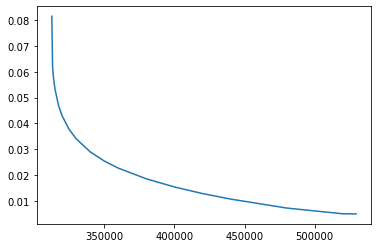

In [19]:
for bs in [54]:

    plt.plot(EF[bs].iloc[-2], EF[bs].iloc[-1])
plt.show()

In [20]:
# pickle
import pickle

file = open('result_constrained.pkl', 'wb')

# dump information to that file
pickle.dump(EF, file)

# close the file
file.close()


file1 = open('LM.pkl', 'wb')

# dump information to that file
pickle.dump(LM, file1)

# close the file
file1.close()

### NOTE: need to add Var(demand) back to the quadratic risk objective in the analysis

This was done in the copperplate case for all bootstrap solutions (solution_bootstrap_addbackVard.ipynb) but not here. 

In [21]:
LM[54]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_max,-33915.193156,1.641736e-01,1.098570e-01,7.486974e-02,4.860639e-02,3.653161e-02,2.618119e-02,2.117529e-02,1.551470e-02,1.199085e-02,9.844050e-03,7.532669e-03,6.206237e-03,5.196725e-03,4.437975e-03,3.135660e-03,1.584641e-03,0.001116
ADE_max,-19111.660182,8.720507e-02,5.705486e-02,3.767289e-02,2.320250e-02,1.678056e-02,1.097499e-02,8.467738e-03,5.547443e-03,3.709436e-03,2.465506e-03,1.539345e-03,1.166341e-03,9.018246e-04,7.284165e-04,4.473728e-04,1.958584e-11,0.000000
SESA_max,-1791.235543,8.079086e-03,5.714982e-03,4.646984e-03,3.431270e-03,2.700975e-03,1.960419e-03,1.648735e-03,1.309247e-03,1.097157e-03,9.577461e-04,7.209722e-04,4.926700e-04,3.338277e-04,2.604035e-04,1.225167e-04,2.669160e-12,0.000000
NQ_max,-72522.598197,3.535627e-01,2.357511e-01,1.609693e-01,1.062490e-01,8.225063e-02,6.113092e-02,5.033548e-02,3.858043e-02,3.214744e-02,2.793856e-02,2.262099e-02,1.912080e-02,1.642712e-02,1.425535e-02,1.061136e-02,6.216098e-03,0.005799
CQ_max,-35059.909082,1.772146e-01,1.198020e-01,8.347818e-02,5.627065e-02,4.410235e-02,3.339864e-02,2.765835e-02,2.093421e-02,1.719862e-02,1.489369e-02,1.187468e-02,9.852547e-03,8.251957e-03,6.941399e-03,4.688368e-03,2.081083e-03,0.001795
SWQ_max,-20923.226613,9.681708e-02,6.329519e-02,4.159262e-02,2.602170e-02,1.910764e-02,1.306761e-02,1.008368e-02,6.829792e-03,5.132574e-03,4.206562e-03,3.175917e-03,2.528143e-03,1.997337e-03,1.571999e-03,5.304586e-04,6.303201e-12,0.000000
SEQ_max,-0.000000,2.652082e-04,9.246377e-04,1.446880e-03,1.315178e-03,1.289080e-03,1.002631e-03,7.981530e-04,1.987035e-04,5.861766e-11,9.430880e-13,1.039235e-12,2.920562e-13,2.604692e-13,4.167086e-14,8.818218e-13,5.983352e-14,0.000000
NNS_max,-4137.171233,2.011596e-02,1.353956e-02,8.752267e-03,5.462810e-03,3.704530e-03,2.092129e-03,1.199775e-03,4.128320e-04,3.790720e-05,1.845956e-12,2.135884e-12,3.866413e-13,3.387637e-13,4.615305e-14,2.224431e-12,9.473525e-14,0.000000
NCEN_max,-58.704716,5.263492e-13,4.131643e-13,6.930325e-13,2.652672e-14,4.476901e-13,2.332672e-14,2.851452e-14,1.174958e-13,3.413165e-13,3.140525e-14,5.748004e-14,1.963306e-14,2.109080e-14,1.333921e-14,6.463293e-14,3.359330e-14,0.000000
SWNSW_max,-13748.944510,6.348518e-02,4.049469e-02,2.646527e-02,1.578067e-02,1.056709e-02,6.711695e-03,4.837948e-03,2.804510e-03,1.451454e-03,7.295688e-04,2.139579e-04,9.718010e-05,1.929223e-05,5.429586e-13,3.773015e-12,1.413530e-13,0.000000


In [22]:
EF[54]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.071112,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02
ADE_wind,0.142028,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.325071e-01,1.203460e-01,1.080554e-01,9.331723e-02,6.762321e-02,3.042757e-03,2.248948e-18
SESA_wind,0.023256,3.428153e-02,3.637881e-02,3.461721e-02,2.551738e-02,2.203335e-02,2.214666e-02,1.595007e-02,5.774087e-03,7.374356e-10,3.248059e-11,9.472411e-11,8.619218e-11,1.918878e-03,8.936365e-03,1.880651e-02,2.452116e-02,1.782857e-02
NQ_wind,0.082693,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02
CQ_wind,0.099798,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02
SWQ_wind,0.167561,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.456528e-01,1.407734e-01
SEQ_wind,0.002059,6.623528e-02,8.229733e-02,1.047659e-01,1.335007e-01,1.419371e-01,1.496986e-01,1.502610e-01,1.483680e-01,1.430869e-01,1.334262e-01,1.161793e-01,1.008941e-01,8.719721e-02,7.293953e-02,4.090244e-02,5.052481e-02,5.646531e-02
NNS_wind,0.116660,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.003977e-01,8.328374e-02,6.547368e-02,4.528416e-02,2.799892e-02,1.176592e-02,1.140188e-10,2.422133e-09,2.619867e-11,2.265661e-19
NCEN_wind,0.220176,2.060087e-01,2.039389e-01,1.972689e-01,1.751990e-01,1.606339e-01,1.345031e-01,1.146067e-01,1.004285e-01,9.359326e-02,8.814248e-02,8.082579e-02,7.799005e-02,7.585551e-02,7.308282e-02,5.375712e-02,3.855303e-02,3.102202e-02
SWNSW_wind,0.086327,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,7.496364e-02,6.061417e-02,4.934222e-02,3.702204e-02,1.239167e-02,1.157427e-11,-1.488137e-17


In [23]:
EF[54][:32].sum()

1     2.282534
2     2.204153
3     2.167518
4     2.119540
5     2.046114
6     1.990151
7     1.906220
8     1.841613
9     1.740586
10    1.658707
11    1.588149
12    1.474581
13    1.378915
14    1.295025
15    1.219780
16    1.080658
17    1.000000
18    1.000000
dtype: float64